In [1]:
import copy, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Normalizer

In [2]:
class Normalizer:
    def __init__(self, normalize=True):
        self.normalize = normalize
        self.X_mean, self.X_std = None, None
        self.y_mean, self.y_std = None, None

    def fit_transform(self, X, y):
        if not self.normalize:
            return X, y

        # Compute mean/std
        self.X_mean = np.mean(X, axis=0)
        self.X_std = np.std(X, axis=0)
        self.X_std[self.X_std == 0] = 1

        self.y_mean = np.mean(y)
        self.y_std = np.std(y) if np.std(y) != 0 else 1

        # Normalize
        X_scaled = (X - self.X_mean) / self.X_std
        y_scaled = (y - self.y_mean) / self.y_std

        return X_scaled, y_scaled

    def transform_X(self, X):
        if not self.normalize:
            return X
        return (X - self.X_mean) / self.X_std

    def inverse_y(self, y_scaled):
        if not self.normalize:
            return y_scaled
        return y_scaled * self.y_std + self.y_mean

#### LinearRegression

In [ ]:
class LinearRegression:
    def __init__(self, lr=0.001, epochs=10000, normalize=True):
        self.lr = lr
        self.epochs = epochs
        self.normalize = normalize
        self.w = None
        self.b = 0.0
        self.J_history = []
        self.normalizer = Normalizer(normalize)

    # Cost function
    def compute_cost(self, X, y):
        m = X.shape[0]
        total_cost = 0.0
        for i in range(m):
            f_wb_i = np.dot(X[i], self.w) + self.b
            total_cost += (f_wb_i - y[i])**2
        return total_cost / (2 * m)

    # Gradient function
    def compute_gradient(self, X, y):
        m, n = X.shape
        dj_dw = np.zeros(n)
        dj_db = 0.0

        for i in range(m):
            err = np.dot(X[i], self.w) + self.b - y[i]
            dj_dw += err * X[i]
            dj_db += err

        dj_dw /= m
        dj_db /= m
        return dj_dw, dj_db

    # Fit model
    def fit(self, X, y, verbose=True):
        # Normalize
        X, y = self.normalizer.fit_transform(X, y)

        # Initialize params
        self.w = np.zeros(X.shape[1])
        self.b = 0.0

        # Gradient Descent
        for i in range(self.epochs):
            dj_dw, dj_db = self.compute_gradient(X, y)
            self.w -= self.lr * dj_dw
            self.b -= self.lr * dj_db

            # Save history
            if i < 100000:
                self.J_history.append(self.compute_cost(X, y))

            if verbose and i % max(1, self.epochs // 10) == 0:
                print(f"Iteration {i:6d}: Cost {self.J_history[-1]:.4f}")

        print("\n✅ Training completed.")

    # Predict
    def predict(self, X):
        X = self.normalizer.transform_X(X)
        y_scaled = np.dot(X, self.w) + self.b
        return self.normalizer.inverse_y(y_scaled)

    # Plot cost history
    def plot_cost(self):
        plt.figure(figsize=(6,4))
        plt.plot(self.J_history)
        plt.xlabel("Iterations")
        plt.ylabel("Cost (MSE)")
        plt.title("Cost Function over Iterations")
        plt.grid(True)
        plt.show()

#### Load Data

In [4]:
df = pd.read_csv("House-Price.csv")

print("Data Info:")
print(df.info())
print(df.head())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   int64  
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dt

#### EDA

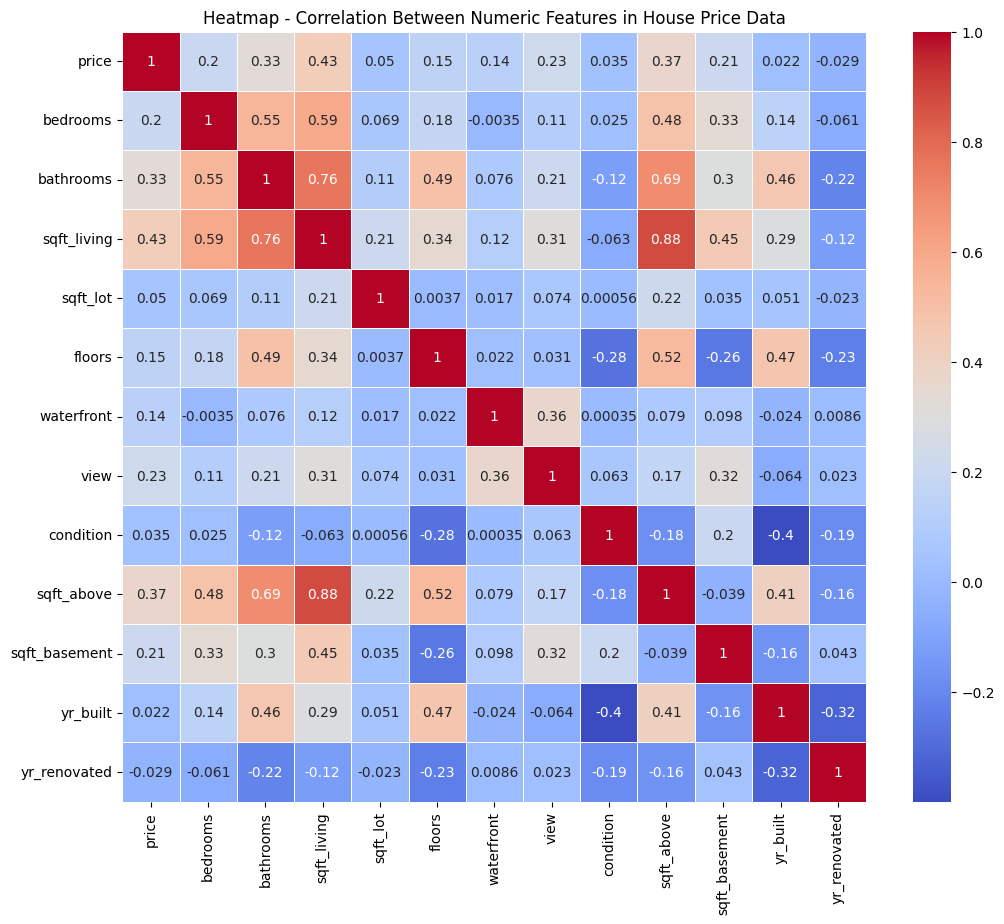

In [5]:
numeric_df = df.select_dtypes(include='number')
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap - Correlation Between Numeric Features in House Price Data")
plt.show()

#### Feature Selection

In [6]:
features = ["bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors"]
X = df[features].values
y = df["price"].values

##### Train/Test Split

In [7]:
def train_test_split(X, y, test_size=0.2, seed=42):
    np.random.seed(seed)
    m = X.shape[0]
    indices = np.random.permutation(m)
    test_count = int(m * test_size)
    test_idx = indices[:test_count]
    train_idx = indices[test_count:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y)

##### Train

In [ ]:
model = LinearRegression(lr=0.001, epochs=10000, normalize=True)
model.fit(X_train, y_train)

# Plot cost history
model.plot_cost()

Iteration      0: Cost 0.4991
Iteration   1000: Cost 0.3016
Iteration   2000: Cost 0.2829
Iteration   3000: Cost 0.2734
Iteration   4000: Cost 0.2681
Iteration   5000: Cost 0.2651
Iteration   6000: Cost 0.2632
Iteration   7000: Cost 0.2621


##### Evaluation

In [ ]:
def rmse(y_true, y_pred):
    return math.sqrt(np.mean((y_true - y_pred) ** 2))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

X Shape: (4600, 5), X Type:<class 'numpy.ndarray'>)
[[ 3.     1.5    1.34   7.912  1.5  ]
 [ 5.     2.5    3.65   9.05   2.   ]
 [ 3.     2.     1.93  11.947  1.   ]
 ...
 [ 3.     2.5    3.01   7.014  2.   ]
 [ 4.     2.     2.09   6.63   1.   ]
 [ 3.     2.5    1.49   8.102  2.   ]]
y Shape: (4600,), y Type:<class 'numpy.ndarray'>)
[ 3.13       23.84        3.42       ...  4.16904167  2.034
  2.206     ]


##### Prediction

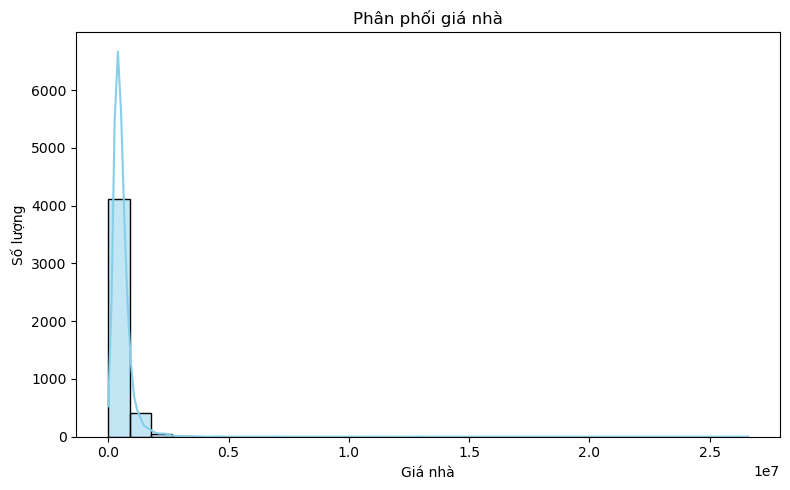

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

print("\n📈 Training Evaluation:")
print(f"RMSE: {rmse(y_train, y_train_pred):.4f}")
print(f"MAE : {mae(y_train, y_train_pred):.4f}")
print(f"R²  : {r2_score(y_train, y_train_pred):.4f}")

print("\n📉 Testing Evaluation:")
print(f"RMSE: {rmse(y_test, y_test_pred):.4f}")
print(f"MAE : {mae(y_test, y_test_pred):.4f}")
print(f"R²  : {r2_score(y_test, y_test_pred):.4f}")

##### Visualization

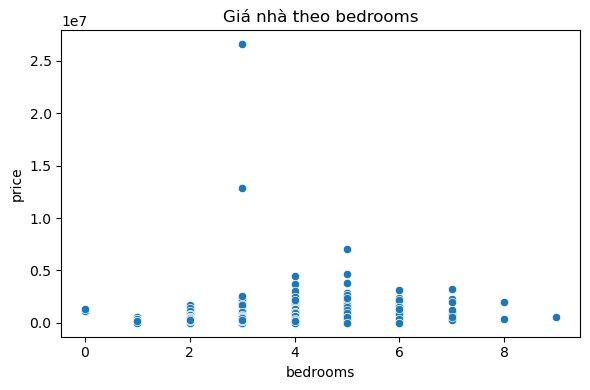

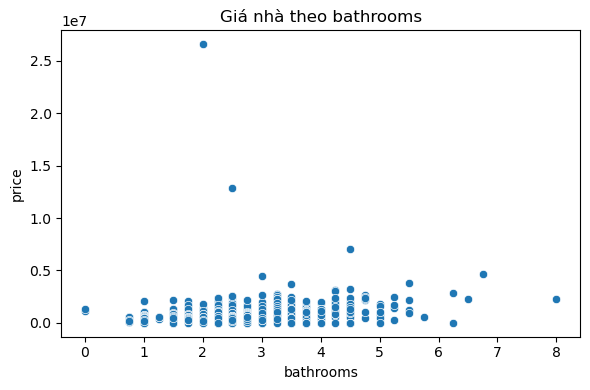

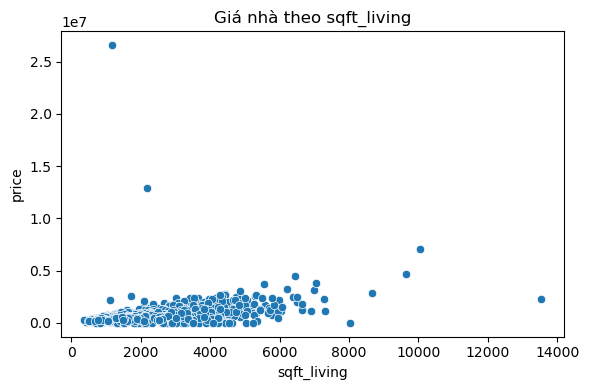

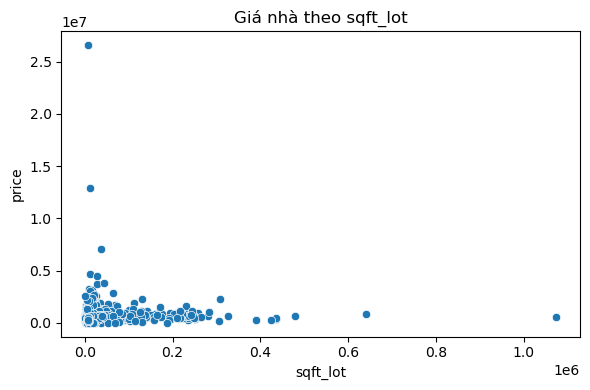

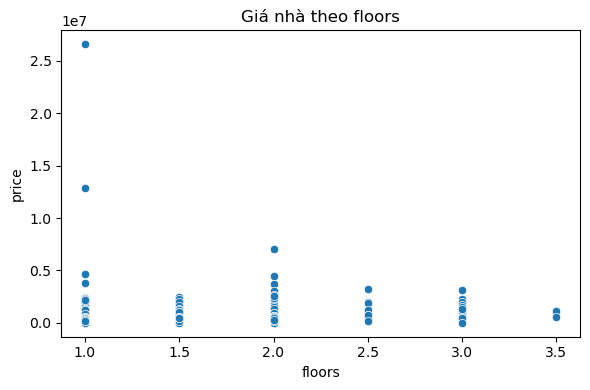

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted (Test set)")
plt.show()
